
Домашнее задание «Модели ARIMA»

Выберите ряд из первого задания и постройте его модель ARIMA

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
%matplotlib inline

In [2]:
import tqdm
from sklearn.metrics import mean_squared_error
from math import sqrt
from warnings import filterwarnings
filterwarnings('ignore')

In [12]:
df = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")

In [13]:
df.head()

,Week,Close
0,1971-W27,890.19
1,1971-W28,901.80
2,1971-W29,888.51
3,1971-W30,887.78
4,1971-W31,858.43


In [15]:
df['weekly_ret'] = np.log(df['Close']).diff()
df.head()

,Week,Close,weekly_ret
0,1971-W27,890.19,NaN
1,1971-W28,901.80,0.012958
2,1971-W29,888.51,-0.014847
3,1971-W30,887.78,-0.000822
4,1971-W31,858.43,-0.033619


In [16]:
# drop null rows
df.dropna(inplace=True)

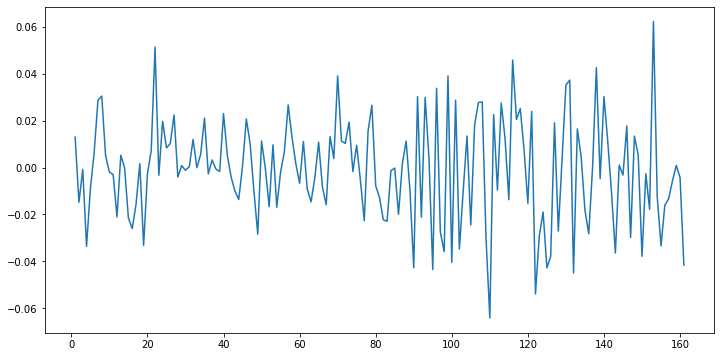

In [17]:
df.weekly_ret.plot(kind='line', figsize=(12, 6));

In [19]:
udiff = df.drop(['Close'], axis=1)
udiff.head()

,Week,weekly_ret
1,1971-W28,0.012958
2,1971-W29,-0.014847
3,1971-W30,-0.000822
4,1971-W31,-0.033619
5,1971-W32,-0.009151


In [20]:
rolmean = udiff.rolling(20).mean()
rolstd = udiff.rolling(20).std()

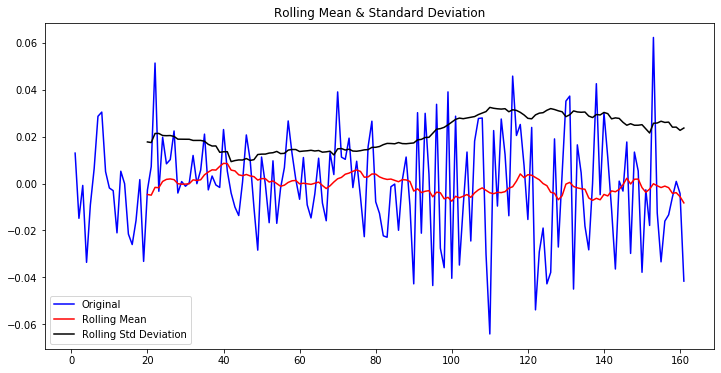

In [24]:
plt.figure(figsize=(12, 6))
orig = plt.plot(udiff['weekly_ret'], color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
plt.title('Rolling Mean & Standard Deviation')
plt.legend(loc='best')
plt.show(block=False)

In [25]:
# Perform Dickey-Fuller test
dftest = sm.tsa.adfuller(udiff.weekly_ret, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value ({0})'.format(key)] = value
    
dfoutput

Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64

P-value меньше 0.05% следоватаельно ряд стационарен

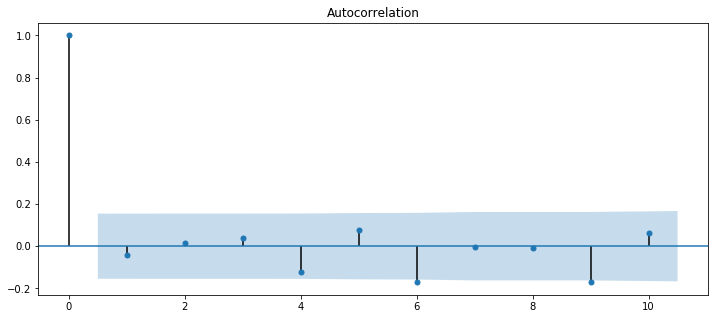

In [27]:
from statsmodels.graphics.tsaplots import plot_acf

# the autocorrelation chart provides just the correlation at increasing lags
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(udiff['weekly_ret'].values, lags=10, ax=ax)
plt.show()

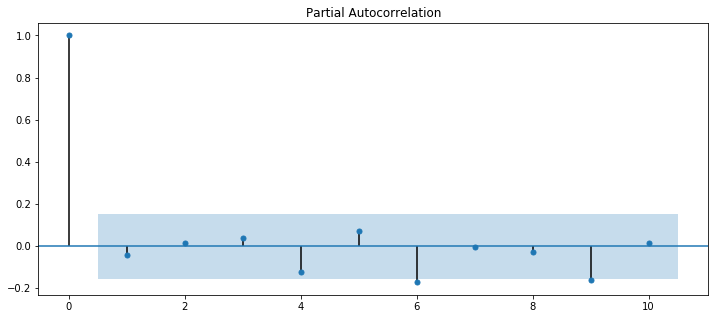

In [28]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(udiff['weekly_ret'].values, lags=10, ax=ax)
plt.show()

In [35]:
from statsmodels.tsa.arima_model import ARMA

ar1 = ARMA(tuple(udiff['weekly_ret'].values), (4, 4)).fit()
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  161
Model:                     ARMA(4, 4)   Log Likelihood                 392.384
Method:                       css-mle   S.D. of innovations              0.021
Date:                Sun, 31 Jan 2021   AIC                           -764.768
Time:                        22:56:34   BIC                           -733.954
Sample:                             0   HQIC                          -752.256
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.002     -0.674      0.501      -0.004       0.002
ar.L1.y       -0.4404        nan        nan        nan         nan         nan
ar.L2.y       -0.0833      0.016     -5.172      0.000      -0.115      -0.052
ar.L3.y       -0.5118        nan        nan        nan         nan         nan
ar.L4.y       -0.9383        nan        nan        nan         nan         nan
ma.L1.y        0.4027      0.038     10.522      0.000       0.328       0.478
ma.L2.y        0.0476      0.029      1.624      0.104      -0.010       0.105
ma.L3.y        0.5627      0.023     24.324      0.000       0.517       0.608
ma.L4.y        0.8621      0.038     22.847      0.000       0.788       0.936
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.5798           -0.8148j            1.0000           -0.1516
AR.2            0.5798           +0.8148j            1.0000            0.1516
AR.3           -0.8525           -0.5822j            1.0323           -0.4046
AR.4           -0.8525           +0.5822j            1.0323            0.4046
MA.1            0.5803           -0.8144j            1.0000           -0.1515
MA.2            0.5803           +0.8144j            1.0000            0.1515
MA.3           -0.9067           -0.5812j            1.0770           -0.4093
MA.4           -0.9067           +0.5812j            1.0770            0.4093
-----------------------------------------------------------------------------
"""

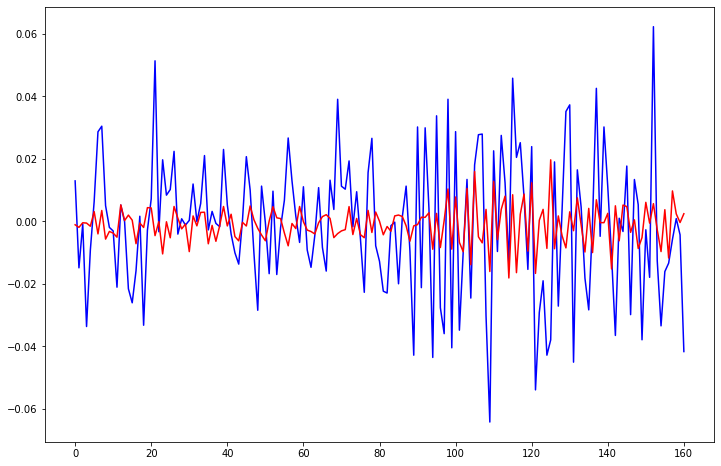

In [36]:
plt.figure(figsize=(12, 8))
plt.plot(udiff['weekly_ret'].values, color='blue')
preds = ar1.fittedvalues
plt.plot(preds, color='red')
plt.show()

Как видим, модель пока не очень хорошо предсказывает

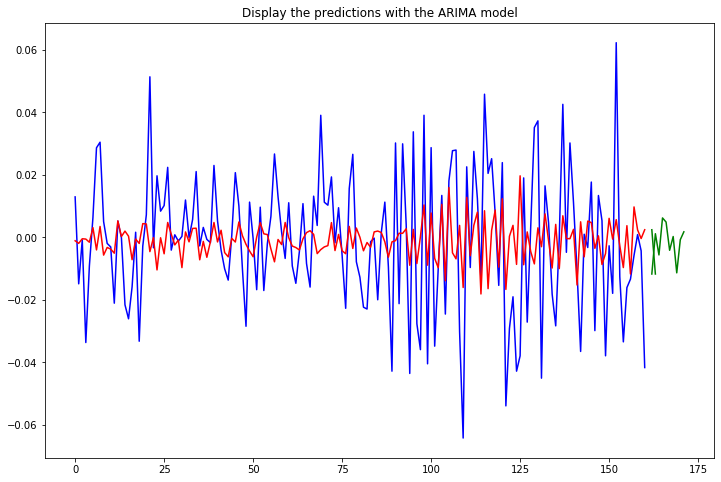

In [39]:
steps = 10

forecast = ar1.forecast(steps=steps)[0]

plt.figure(figsize=(12, 8))
plt.plot(udiff['weekly_ret'].values, color='blue')

preds = ar1.fittedvalues
plt.plot(preds, color='red')

plt.plot(pd.DataFrame(np.array([preds[-1],forecast[0]]).T,index=range(len(udiff['weekly_ret'].values)+1, 
                                                                      len(udiff['weekly_ret'].values)+3)), color='green')
plt.plot(pd.DataFrame(forecast,index=range(len(udiff['weekly_ret'].values)+1, 
                                           len(udiff['weekly_ret'].values)+1+steps)), color='green')
plt.title('Display the predictions with the ARIMA model')
plt.show()

In [ ]:
Пока что только так у меня получилось. Не понимаю, как можно еще улучшить модель